In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#install librosa
!pip install librosa

In [ ]:
#install shap
!pip install shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [ ]:
#more imports
import librosa
from librosa import display
import numpy as np
import os
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import tensorflow.keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import sys
import shap
import pickle

In [ ]:
#decision tree
def DecisionTree(X_train, X_test, y_train, y_test):

  dtree = DecisionTreeClassifier()
  dtree.fit(X_train, y_train)
  predictions = dtree.predict(X_test)
  print(classification_report(y_test,predictions))

  return dtree

In [ ]:
#random forest
def RandomForest(X_train, X_test, y_train, y_test):

  rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                   max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                   n_estimators= 22000, random_state= 5)

  rforest.fit(X_train, y_train)
  predictions = rforest.predict(X_test)
  print(classification_report(y_test,predictions))

  return rforest

In [ ]:
#neural network
def NeuralNetwork(X_train, X_test, y_train, y_test, classnum, label_type):

  x_traincnn = np.expand_dims(X_train, axis=2)
  x_testcnn = np.expand_dims(X_test, axis=2)

  #Begin constructing model layers
  model = Sequential()

  #layers
  model.add(Conv1D(128, 5,padding='same',
                   input_shape=(40,1)))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
  model.add(Flatten())

  #final classification layer
  model.add(Dense(classnum))
  model.add(Activation('softmax'))

  #optimizer
  opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

  #summarize
  model.summary()

  #use categorical cross entropy
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  #Due to differences in the dataset, each set requires a different onehot label encoder
  le = preprocessing.LabelEncoder()

  if(label_type == 'emotion'):
    le.fit(["01", "02", "03", "04", "05", "06", "07", "08"])
    #01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
  elif(label_type == 'gender'):
    le.fit(["m","f"])

  #encode
  y_train_encoded = le.transform(y_train)
  y_test_encoded = le.transform(y_test)

  #fit model
  cnnhistory=model.fit(x_traincnn, y_train_encoded, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test_encoded))

  return model, cnnhistory, x_testcnn

In [ ]:
#path and file list
dataset_name = 'ravdess'
path = '/content/drive/My Drive/Senior/1980/' + dataset_name
lst = []
lst_mod = []

#band
SPEECH_LOW_BAND = 200
SPEECH_HIGH_BAND = 3400

In [ ]:
pickle_flag = "pickleless" #pickle, pickled, or pickleless

In [ ]:
#get whole dataset
if(pickle_flag == 'pickleless' or pickle_flag == 'pickle'):
  for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
          #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
          X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
          mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 

          #modified
          X_mod, sample_rate_mod = librosa.load(os.path.join(subdir,file), sr=None, res_type='kaiser_fast')

          #resample
          X_mod = librosa.core.resample(y=X_mod, orig_sr=sample_rate_mod, target_sr=8192)

          #fourier transform
          stft = librosa.core.stft(y = X_mod)

          #preserve only audio within speech band
          stft[:SPEECH_LOW_BAND] = 0
          stft[SPEECH_HIGH_BAND:len(stft)] = 0

          #reconstruct the audio
          reconstructed = librosa.core.istft(stft)

          #get mfccs of modded file
          mfccs_mod = np.mean(librosa.feature.mfcc(y=reconstructed, sr=8192, n_mfcc=40).T, axis=0) 
          
          #file1 - emotion; file2 - gender
          file1 = ""
          file2 = ""

          #emotion label
          file1 = file[6:8]

          num_male = 0
          num_female = 0

          #gender label
          if(int(file[-6:-4]) % 2 == 0):
            file2 = 'f'
            num_female = num_female + 1
          else:
            file2 = 'm'
            num_male = num_male + 1

          #append to list
          arr = mfccs, mfccs_mod, file1, file2
          lst.append(arr)

        # If the file is not valid, skip it
        except ValueError:
          continue

  #pickle if necessary
  if(pickle_flag == 'pickle'):
    with open('list.pkl', 'wb') as f:
      pickle.dump(lst, f)

In [ ]:
#load if necessary
if(pickle == 'pickled'):
  f = open(path + 'list.pkl', 'rb')
  lst = pickle.load(f)

In [ ]:
#get full arrays
X, X_mod, y_emotion, y_gender = zip(*lst)
X = np.asarray(X)
X_mod = np.asarray(X_mod)
y_emotion = np.asarray(y_emotion)
y_gender = np.asarray(y_gender)

In [ ]:
#split into training and testing data
X_train, X_test, X_mod_train, X_mod_test, y_train_emo, y_test_emo, y_train_gender, y_test_gender = train_test_split(X, X_mod, y_emotion, y_gender,test_size=0.20,random_state=42)

In [ ]:
#split training data into training and validation sets
X_train, X_val, X_mod_train, X_mod_val, y_train_emo, y_val_emo, y_train_gender, y_val_gender = train_test_split(X_train, X_mod_train,y_train_emo,y_train_gender,test_size = 0.20)

In [ ]:
#get conditional sets from test split

#arrays:
#
#X_mod_train - y_train_emo - y_train_gender
#X_mod_val - y_val_emo - y_val_gender
#
#X_train - y_train_emo - y_train_gender
#X_val - y_val_emo - y_val_gender
#
#X_test - y_test_emo - y_test_gender
#X_test_male - y_test_male
#X_test_female - y_test_female
#
#X_mod_test - y_test_emo - y_test_gender
#X_mod_test_male - y_test_male
#X_mod_test_female - y_test_female

#male
X_test_male = []
X_mod_test_male = []
y_test_male = []

#female
X_test_female = []
X_mod_test_female = []
y_test_female = []

#for each test item
for i in range(0, len(y_test_emo)):
  if(y_test_gender[i] == 'm'):
    X_test_male.append(X_test[i])
    X_mod_test_male.append(X_mod_test[i])
    y_test_male.append(y_test_emo[i])
  else:
    X_test_female.append(X_test[i])
    X_mod_test_female.append(X_mod_test[i])
    y_test_female.append(y_test_emo[i])

In [ ]:
#now train the decision tree model

#emotion
treeModel_emotion = DecisionTree(X_train, X_val, y_train_emo, y_val_emo)

#gender
treeModel_gender = DecisionTree(X_train, X_val, y_train_gender, y_val_gender)

              precision    recall  f1-score   support

          01       0.75      0.80      0.77        64
          02       0.84      0.84      0.84       128
          03       0.74      0.75      0.74       106
          04       0.79      0.69      0.74       121
          05       0.80      0.85      0.82       124
          06       0.75      0.75      0.75       122
          07       0.60      0.76      0.67        59
          08       0.85      0.64      0.73        61

    accuracy                           0.77       785
   macro avg       0.76      0.76      0.76       785
weighted avg       0.77      0.77      0.77       785

              precision    recall  f1-score   support

           f       0.98      0.97      0.98       392
           m       0.97      0.98      0.98       393

    accuracy                           0.98       785
   macro avg       0.98      0.98      0.98       785
weighted avg       0.98      0.98      0.98       785



In [ ]:
#now train the random forest model

#emotion
forestModel_emotion = RandomForest(X_train, X_val, y_train_emo, y_val_emo)

#gender
forestModel_gender = RandomForest(X_train, X_val, y_train_gender, y_val_gender)

              precision    recall  f1-score   support

          01       1.00      0.73      0.85        64
          02       0.70      0.98      0.82       128
          03       0.85      0.70      0.77       106
          04       0.79      0.67      0.73       121
          05       0.81      0.91      0.86       124
          06       0.74      0.70      0.72       122
          07       0.61      0.56      0.58        59
          08       0.71      0.67      0.69        61

    accuracy                           0.77       785
   macro avg       0.78      0.74      0.75       785
weighted avg       0.78      0.77      0.76       785

              precision    recall  f1-score   support

           f       0.98      1.00      0.99       392
           m       1.00      0.98      0.99       393

    accuracy                           0.99       785
   macro avg       0.99      0.99      0.99       785
weighted avg       0.99      0.99      0.99       785



In [ ]:
#now train the neural network

#emotion
nnModel_emotion = NeuralNetwork(X_train, X_val, y_train_emo, y_val_emo, 8, "emotion")

#gender
nnModel_gender = NeuralNetwork(X_train, X_val, y_train_gender, y_val_gender, 2, "gender")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 128)           768       
                                                                 
 activation (Activation)     (None, 40, 128)           0         
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_1 (Activation)   (None, 5, 128)            0         
                                                        

In [ ]:
#import confusion matrices
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
#get multilabel confusion matrix for emotion 

#make predictions - probability format
nn_pred_emotion = nnModel_emotion[0].predict(X_test)

In [ ]:
#label encoder
le = preprocessing.LabelEncoder()
le.fit(["01", "02", "03", "04", "05", "06", "07", "08"])

LabelEncoder()

In [ ]:
#predictions to numbers
nn_pred_emotion_conv = np.argmax(nn_pred_emotion, axis=1)

In [ ]:
#true labels to numbers
y_test_emo_conv = le.transform(y_test_emo)

In [ ]:
#multilabel confusion matrix
nn_full_emo_matrix = multilabel_confusion_matrix(y_test_emo_conv, nn_pred_emotion_conv)

In [ ]:
#modified version
nn_mod_pred_emotion = nnModel_emotion[0].predict(X_mod_test)
nn_mod_pred_emotion_conv = np.argmax(nn_mod_pred_emotion, axis=1)
nn_mod_full_emo_matrix = multilabel_confusion_matrix(y_test_emo_conv, nn_mod_pred_emotion_conv)

In [ ]:
#gender predictions for nn
nn_pred_gender = nnModel_gender[0].predict(X_test)

In [ ]:
#label encoder
le2 = preprocessing.LabelEncoder()
le2.fit(["m", "f"])

LabelEncoder()

In [ ]:
#to numerical format
nn_pred_gender_conv = np.argmax(nn_pred_gender, axis=1)

In [ ]:
#true labels to numbers
y_test_gender_conv = le2.transform(y_test_gender)

In [ ]:
#confusion matrix
nn_full_gender_matrix = confusion_matrix(y_test_gender_conv, nn_pred_gender_conv)

In [ ]:
X_test_male_np = np.array(X_test_male)
X_mod_test_male_np = np.array(X_mod_test_male)

In [ ]:
#conditional predictions for nn
nn_pred_male = nnModel_emotion[0].predict(X_test_male_np)

In [ ]:
#pred to #
nn_pred_male_conv = np.argmax(nn_pred_male, axis=1)

In [ ]:
#true labels to #
y_test_male_conv = le.transform(y_test_male)

In [ ]:
#confusion matrix
nn_male_emo_matrix = multilabel_confusion_matrix(y_test_male_conv, nn_pred_male_conv)

In [ ]:
#modified version
nn_mod_pred_male = nnModel_emotion[0].predict(X_mod_test_male_np)
nn_mod_pred_male_conv = np.argmax(nn_mod_pred_male, axis=1)
nn_mod_male_emo_matrix = multilabel_confusion_matrix(y_test_male_conv, nn_mod_pred_male_conv)

In [ ]:
#female predictions
X_test_female_np = np.array(X_test_female)
X_mod_test_female_np = np.array(X_mod_test_female)

In [ ]:
#conditional predictions
nn_pred_female = nnModel_emotion[0].predict(X_test_female_np)

In [ ]:
#pred to #
nn_pred_female_conv = np.argmax(nn_pred_female, axis=1)

In [ ]:
#true to #
y_test_female_conv = le.transform(y_test_female)

In [ ]:
#confusion matrix
nn_female_emo_matrix = multilabel_confusion_matrix(y_test_female_conv, nn_pred_female_conv)

In [ ]:
#modified version
nn_mod_pred_female = nnModel_emotion[0].predict(X_mod_test_female_np)
nn_mod_pred_female_conv = np.argmax(nn_mod_pred_female, axis=1)
nn_mod_female_emo_matrix = multilabel_confusion_matrix(y_test_female_conv, nn_mod_pred_female_conv)

In [ ]:
#now the random forest model

#predict emotions on test set
rf_emo_pred = forestModel_emotion.predict(X_test)

In [ ]:
#print multilabel confusion matrix
rf_full_emo_matrix = multilabel_confusion_matrix(y_test_emo, rf_emo_pred)

In [ ]:
#modified version
rf_mod_emo_pred = forestModel_emotion.predict(X_mod_test)
rf_mod_full_emo_matrix = multilabel_confusion_matrix(y_test_emo, rf_mod_emo_pred)

In [ ]:
#predict genders
rf_gender_pred = forestModel_gender.predict(X_test)

In [ ]:
#gender confusion matrix
rf_full_gender_matrix = confusion_matrix(y_test_gender, rf_gender_pred)

In [ ]:
#predict male emotions
rf_emo_male_pred = forestModel_emotion.predict(X_test_male)

In [ ]:
#male confusion matrix
rf_male_emo_matrix = multilabel_confusion_matrix(y_test_male, rf_emo_male_pred)

In [ ]:
#modified version
rf_mod_emo_male_pred = forestModel_emotion.predict(X_mod_test_male)
rf_mod_male_emo_matrix = multilabel_confusion_matrix(y_test_male, rf_mod_emo_male_pred)

In [ ]:
#predict female emotions
rf_emo_female_pred = forestModel_emotion.predict(X_test_female)

In [ ]:
#female confusion matrix
rf_female_emo_matrix = multilabel_confusion_matrix(y_test_female, rf_emo_female_pred)

In [ ]:
#modified version
rf_mod_emo_female_pred = forestModel_emotion.predict(X_mod_test_female)
rf_mod_female_emo_matrix = multilabel_confusion_matrix(y_test_female, rf_mod_emo_female_pred)

In [ ]:
#now the decision tree model

#predict emotions on test set
dt_emo_pred = treeModel_emotion.predict(X_test)

In [ ]:
#print multilabel confusion matrix
dt_full_emo_matrix = multilabel_confusion_matrix(y_test_emo, dt_emo_pred)

In [ ]:
#modified version
dt_mod_emo_pred = treeModel_emotion.predict(X_mod_test)
dt_mod_full_emo_matrix = multilabel_confusion_matrix(y_test_emo, dt_mod_emo_pred)

In [ ]:
#predict genders
dt_gender_pred = forestModel_gender.predict(X_test)

In [ ]:
#gender confusion matrix
dt_full_gender_matrix = confusion_matrix(y_test_gender, dt_gender_pred)

In [ ]:
#predict male emotions
dt_emo_male_pred = forestModel_emotion.predict(X_test_male)

In [ ]:
#male confusion matrix
dt_male_emo_matrix = multilabel_confusion_matrix(y_test_male, dt_emo_male_pred)

In [ ]:
#modified version
dt_mod_emo_male_pred = forestModel_emotion.predict(X_mod_test_male)
dt_mod_male_emo_matrix = multilabel_confusion_matrix(y_test_male, dt_mod_emo_male_pred)

In [ ]:
#predict female emotions
dt_emo_female_pred = forestModel_emotion.predict(X_test_female)

In [ ]:
#female confusion matrix
dt_female_emo_matrix = multilabel_confusion_matrix(y_test_female, dt_emo_female_pred)

In [ ]:
#modified version
dt_mod_emo_female_pred = forestModel_emotion.predict(X_mod_test_female)
dt_mod_female_emo_matrix = multilabel_confusion_matrix(y_test_female, dt_mod_emo_female_pred)

In [ ]:
#nn_full_emo_matrix
#nn_mod_full_emo_matrix
#nn_full_gender_matrix
#nn_male_emo_matrix
#nn_mod_male_emo_matrix
#nn_female_emo_matrix
#nn_mod_female_emo_matrix
#
#rf_full_emo_matrix
#rf_mod_full_emo_matrix
#rf_full_gender_matrix
#rf_male_emo_matrix
#rf_mod_male_emo_matrix
#rf_female_emo_matrix
#rf_mod_female_emo_matrix
#
#dt_full_emo_matrix
#dt-mod_full_emo_matrix
#dt_full_gender_matrix
#dt_male_emo_matrix
#dt_mod_male_emo_matrix
#dt_female_emo_matrix
#dt_mod_female_emo_matrix

In [ ]:
dt_mod_female_emo_matrix

array([[[443,   0],
        [ 32,   0]],

       [[413,   0],
        [ 62,   0]],

       [[256, 138],
        [ 56,  25]],

       [[383,  23],
        [ 61,   8]],

       [[400,  10],
        [ 61,   4]],

       [[170, 218],
        [ 38,  49]],

       [[444,   0],
        [ 31,   0]],

       [[427,   0],
        [ 48,   0]]])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

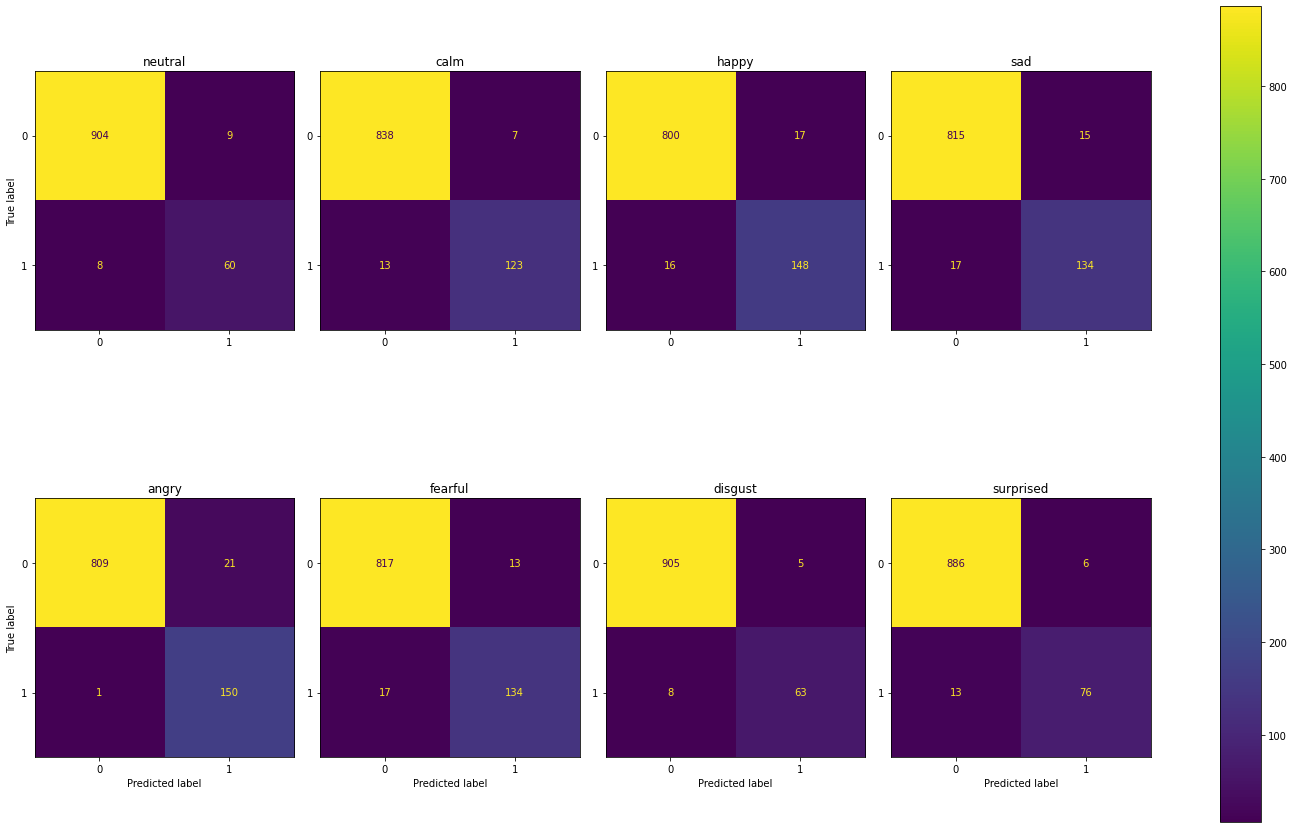

In [ ]:
displaymat = nn_full_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

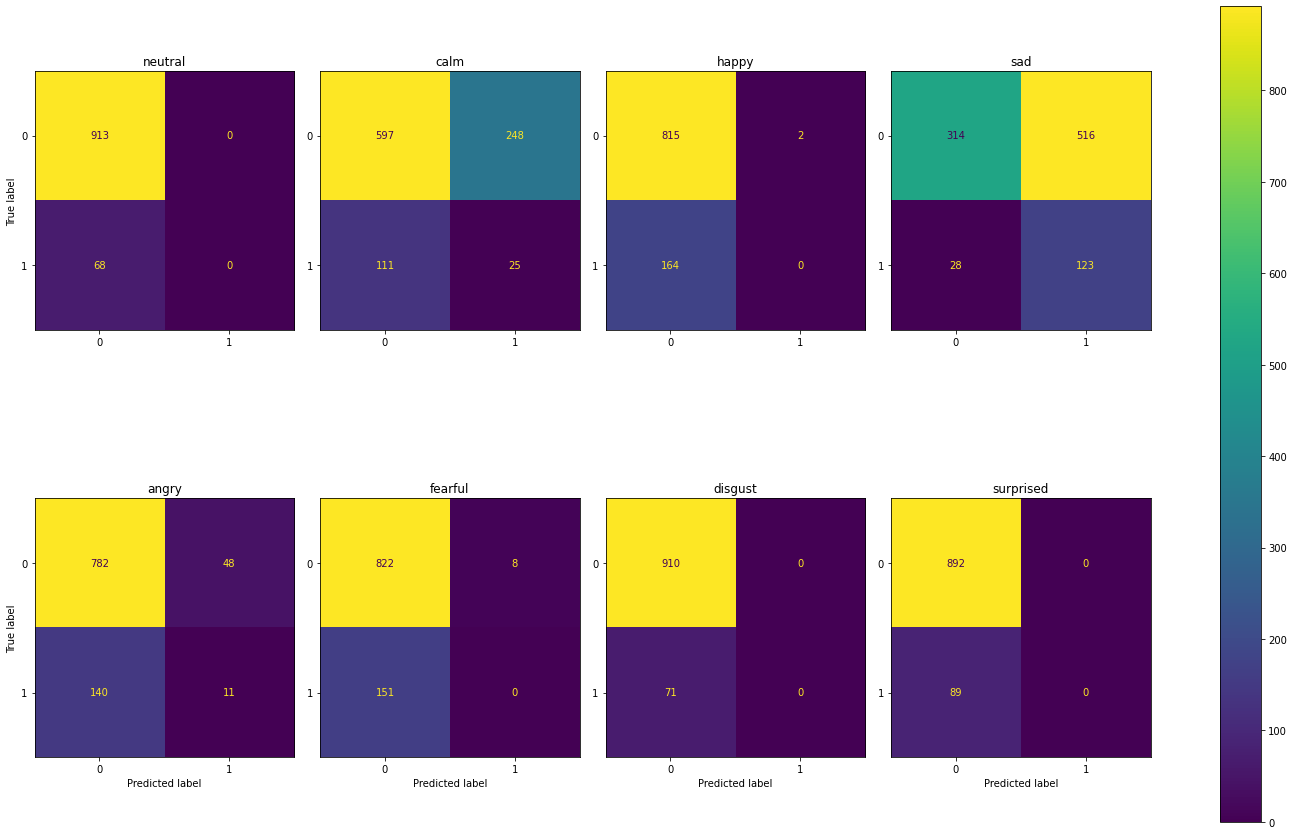

In [ ]:
#nn_mod_full_emo_matrix
displaymat = nn_mod_full_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

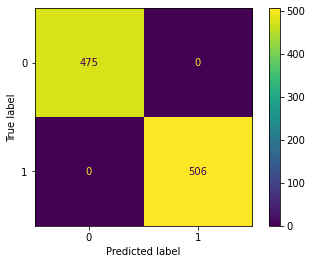

In [ ]:
#nn_full_gender_matrix
displaymat = nn_full_gender_matrix

disp = ConfusionMatrixDisplay(displaymat)
disp.plot()
plt.show()

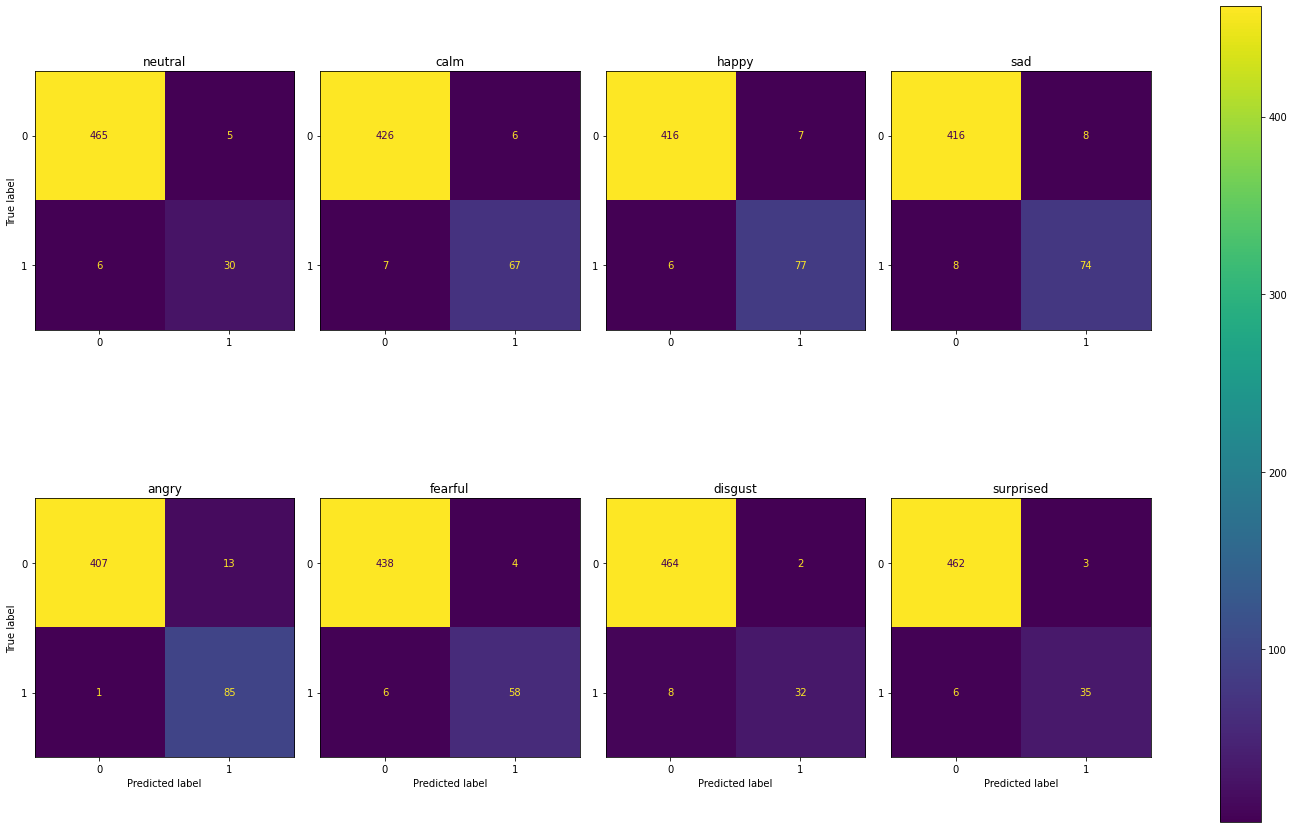

In [ ]:
#nn_male_emo_matrix
displaymat = nn_male_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

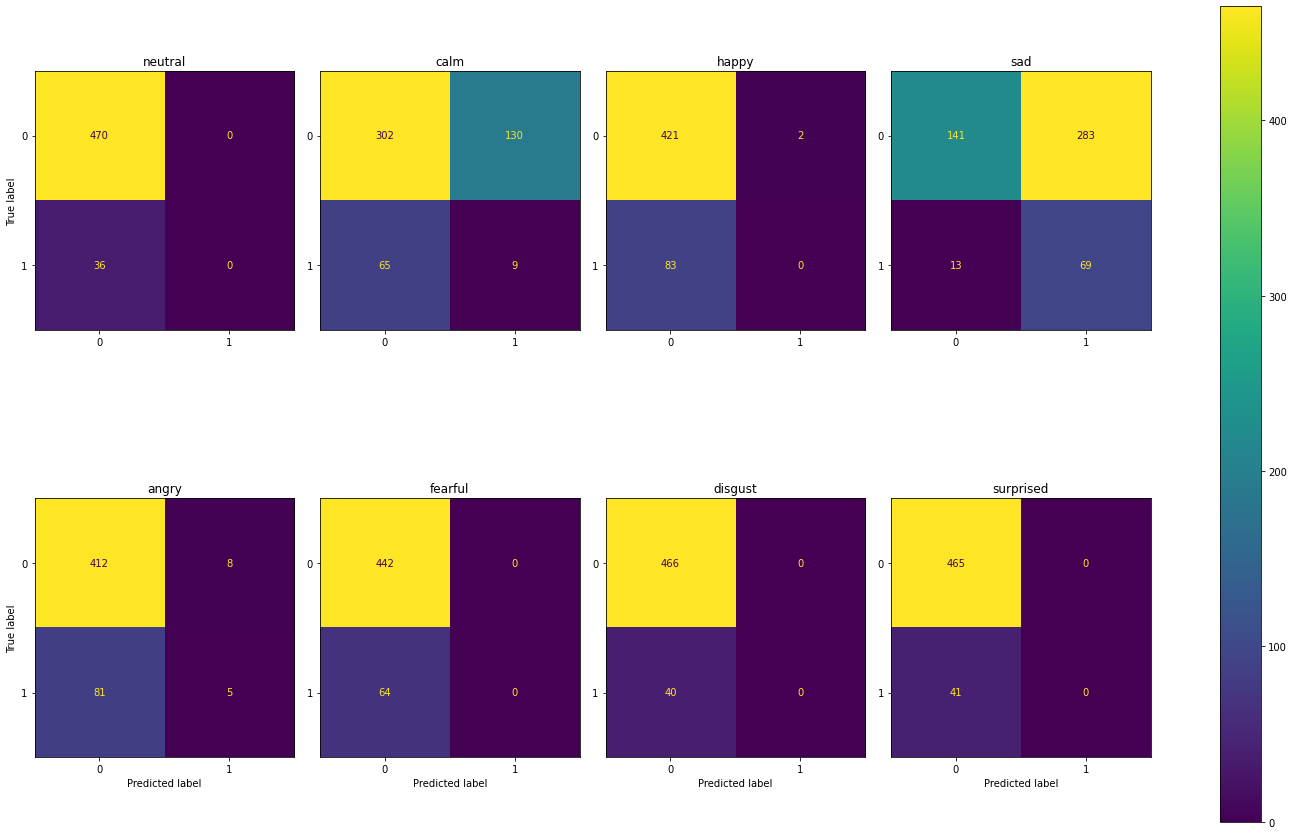

In [ ]:
#nn_mod_male_emo_matrix
displaymat = nn_mod_male_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

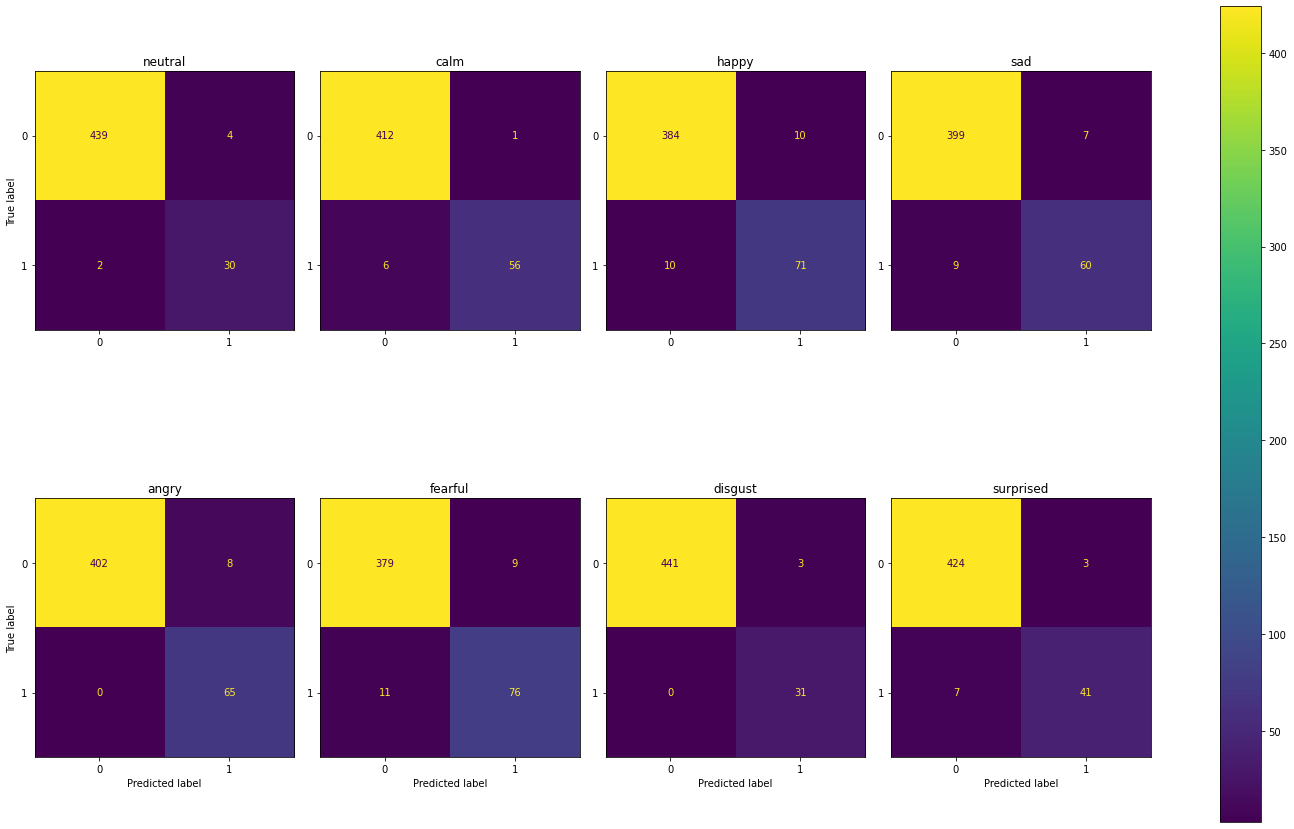

In [ ]:
#nn_female_emo_matrix
displaymat = nn_female_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

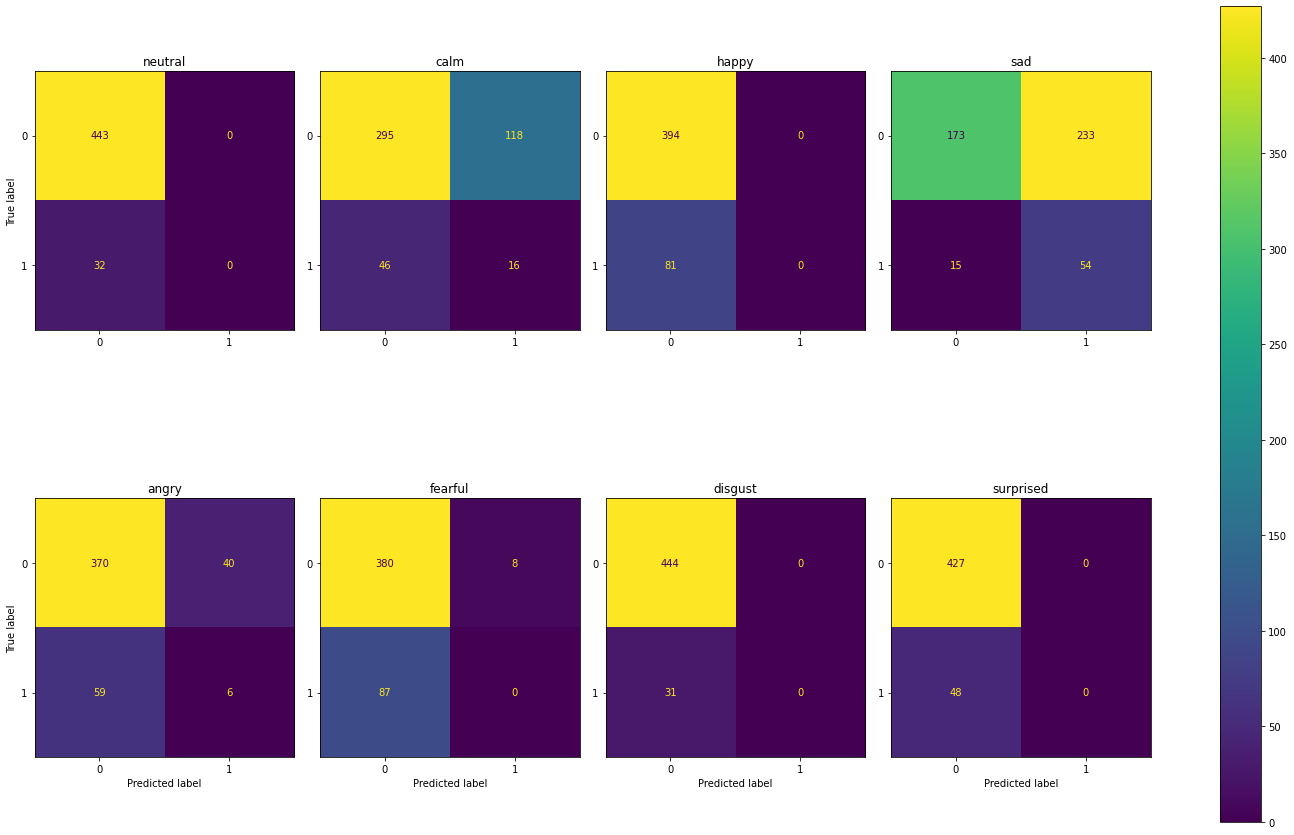

In [ ]:
#nn_mod_female_emo_matrix
displaymat = nn_mod_female_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

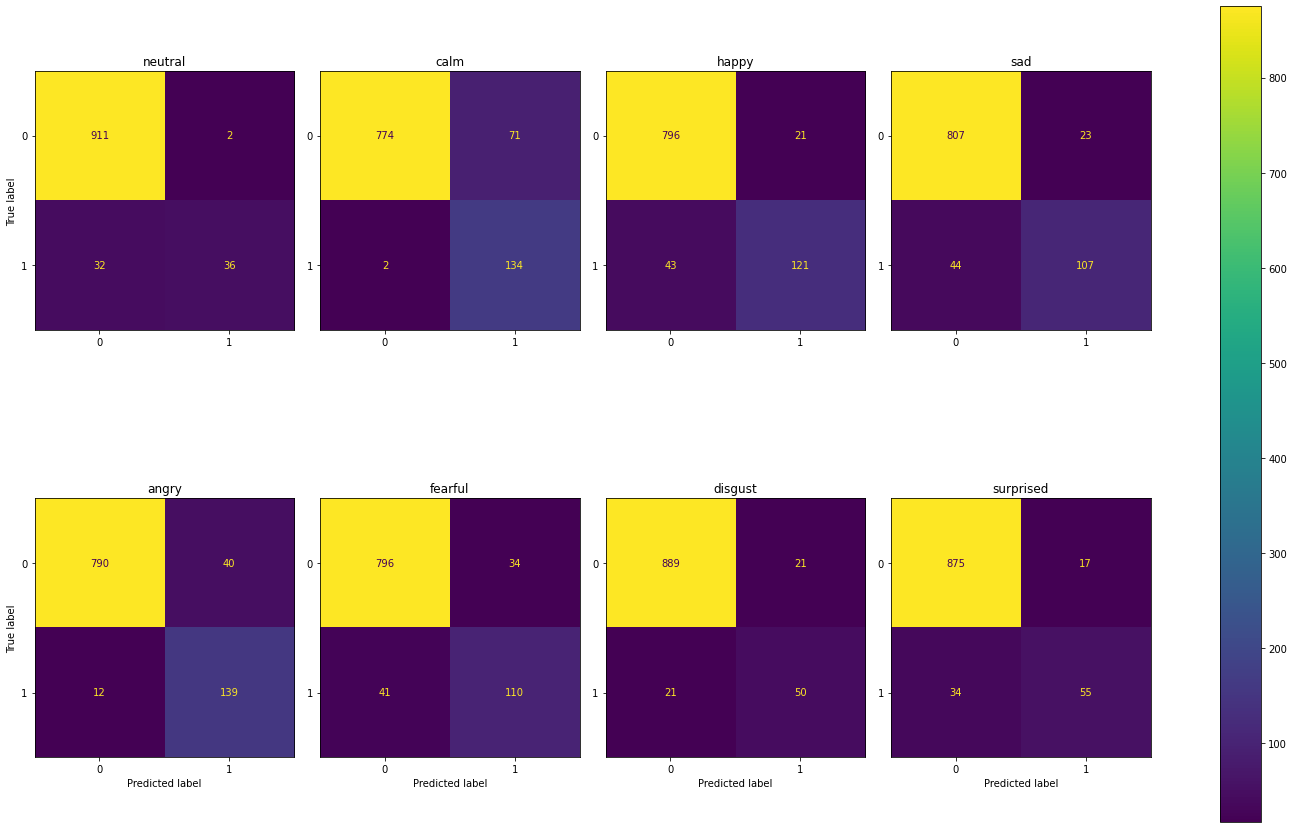

In [ ]:
#rf_full_emo_matrix
displaymat = rf_full_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

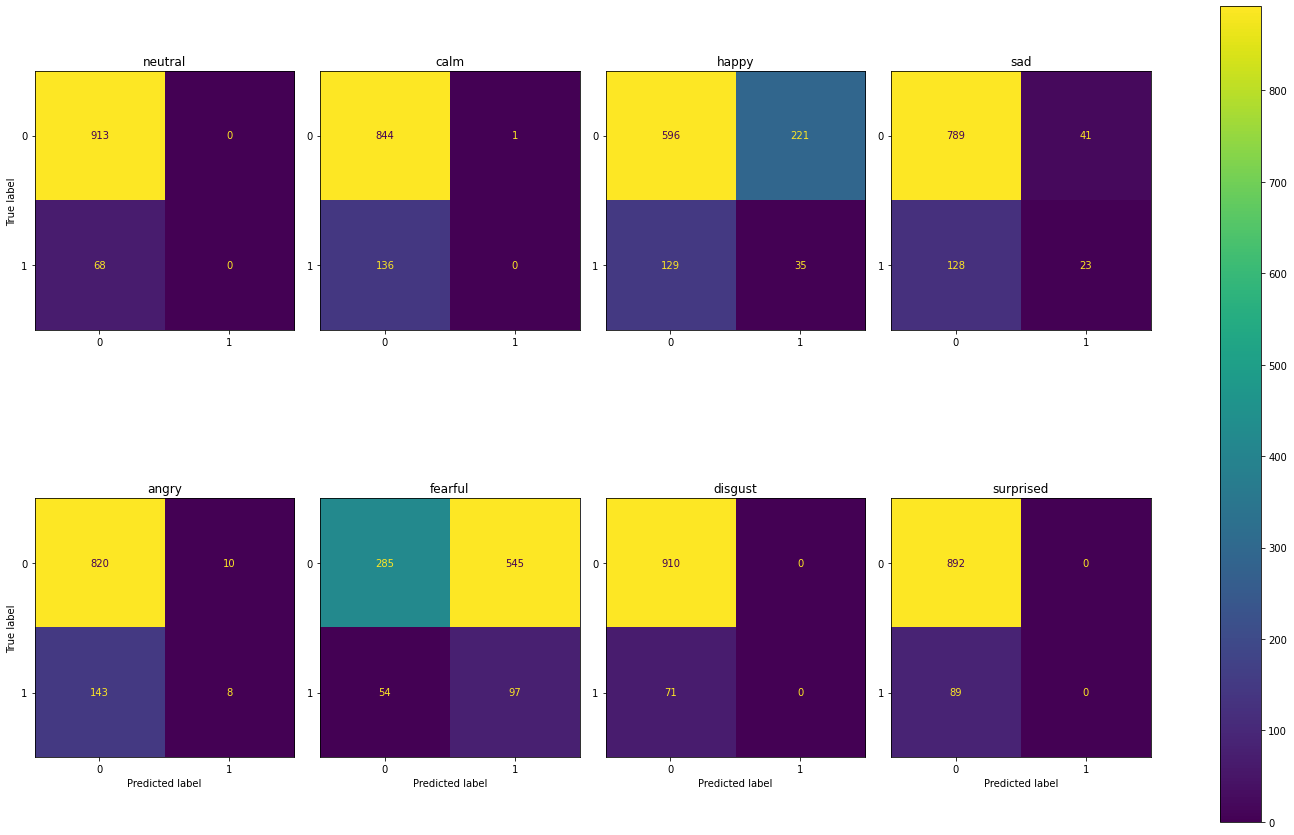

In [ ]:
#rf_mod_full_emo_matrix
displaymat = rf_mod_full_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

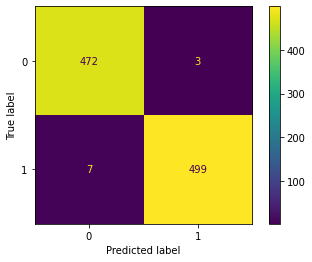

In [ ]:
#rf_full_gender_matrix
displaymat = rf_full_gender_matrix

disp = ConfusionMatrixDisplay(displaymat)
disp.plot()
plt.show()

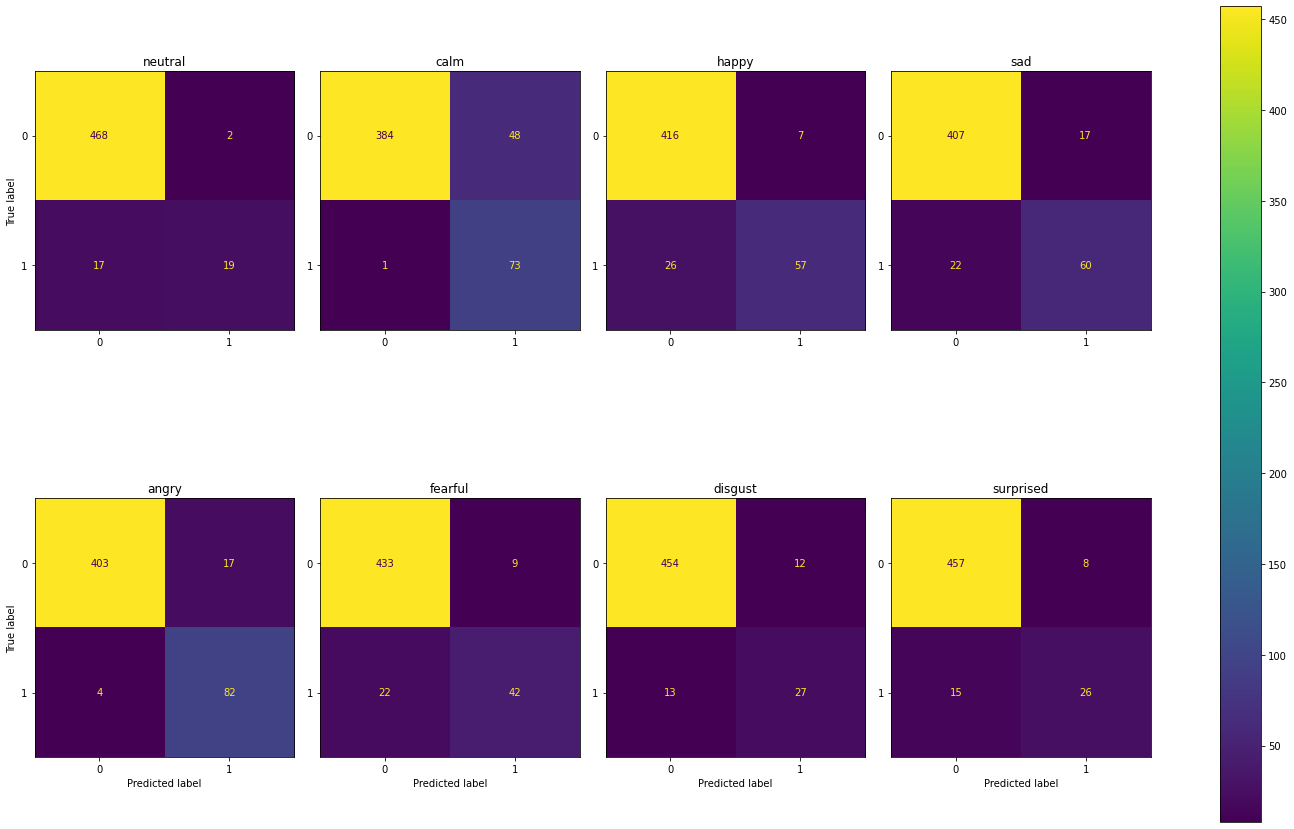

In [ ]:
#rf_male_emo_matrix
displaymat = rf_male_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

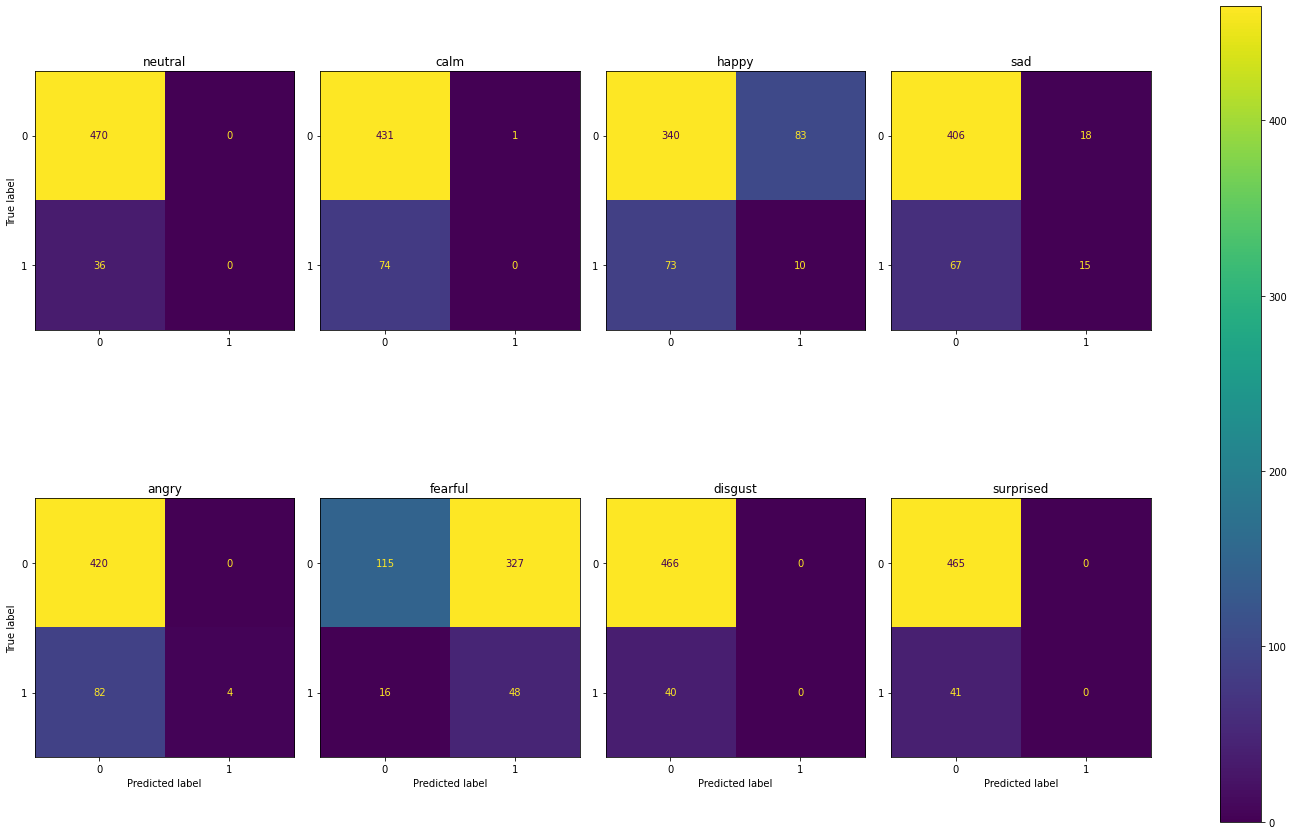

In [ ]:
#rf_mod_male_emo_matrix
displaymat = rf_mod_male_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

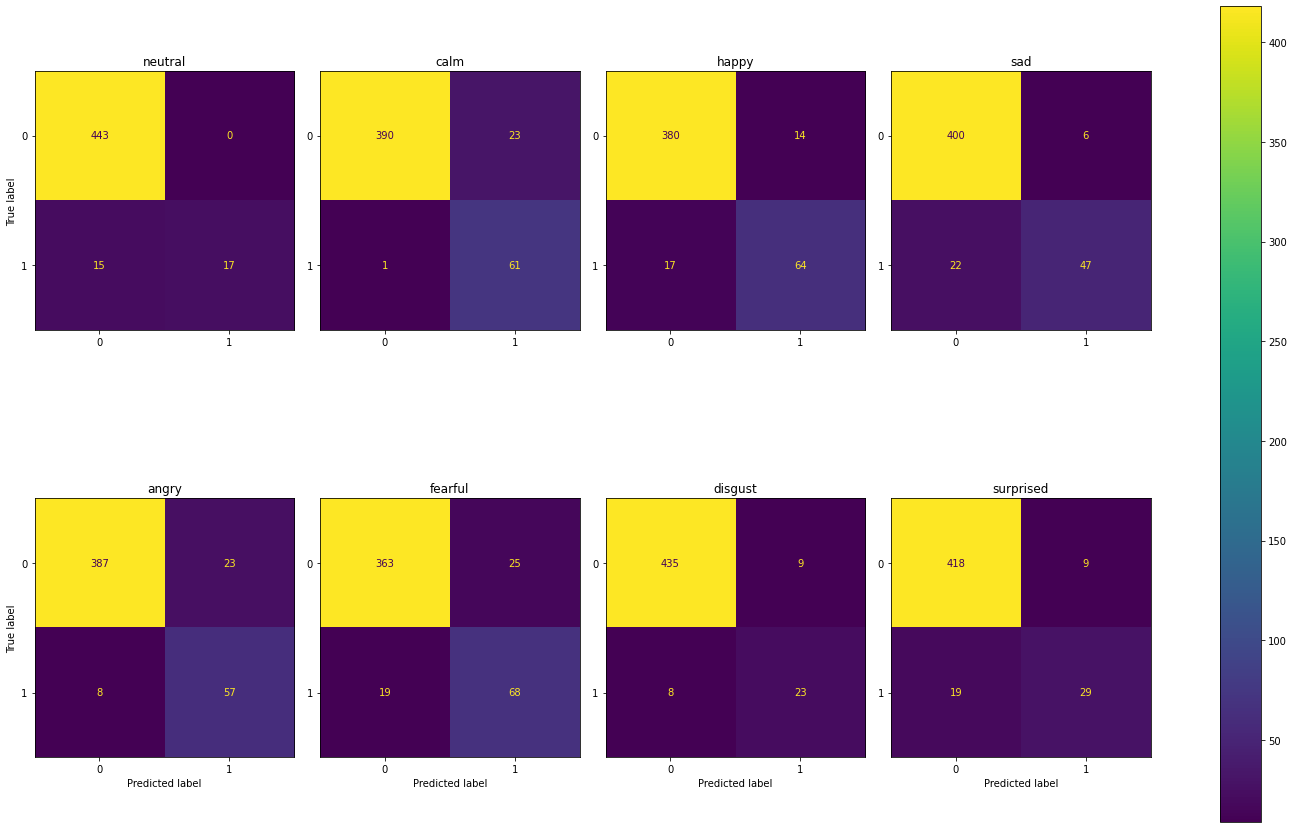

In [ ]:
#rf_female_emo_matrix
displaymat = rf_female_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

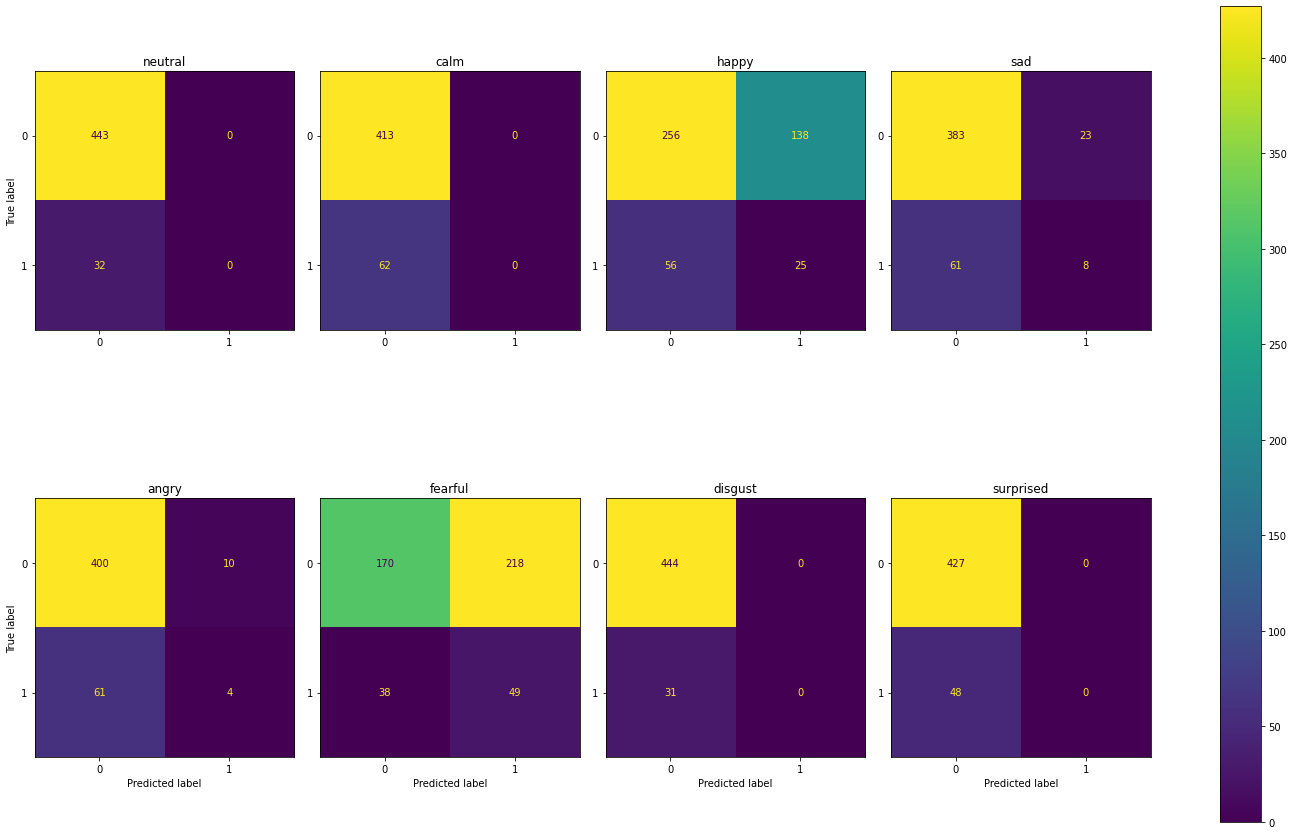

In [ ]:
#rf_mod_female_emo_matrix
displaymat = rf_mod_female_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

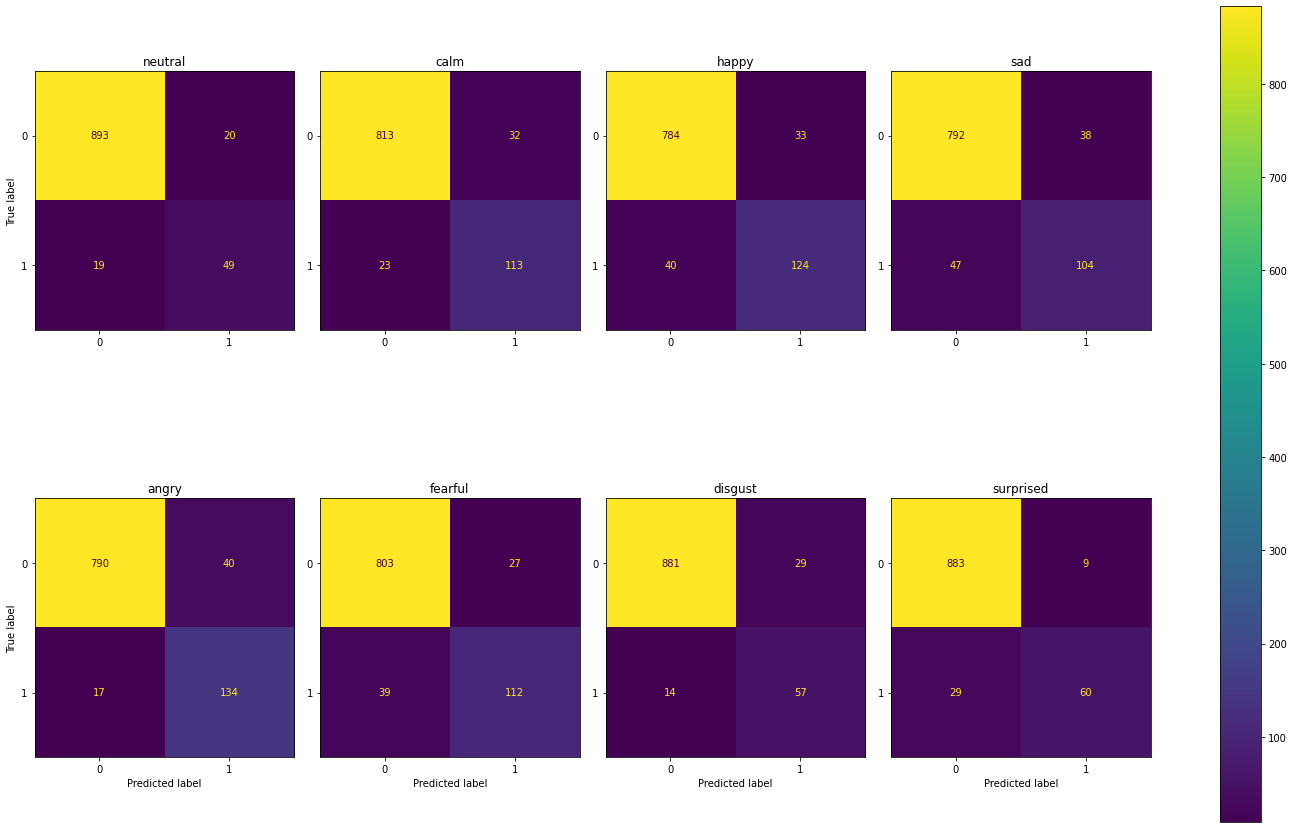

In [ ]:
#dt_full_emo_matrix
displaymat = dt_full_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

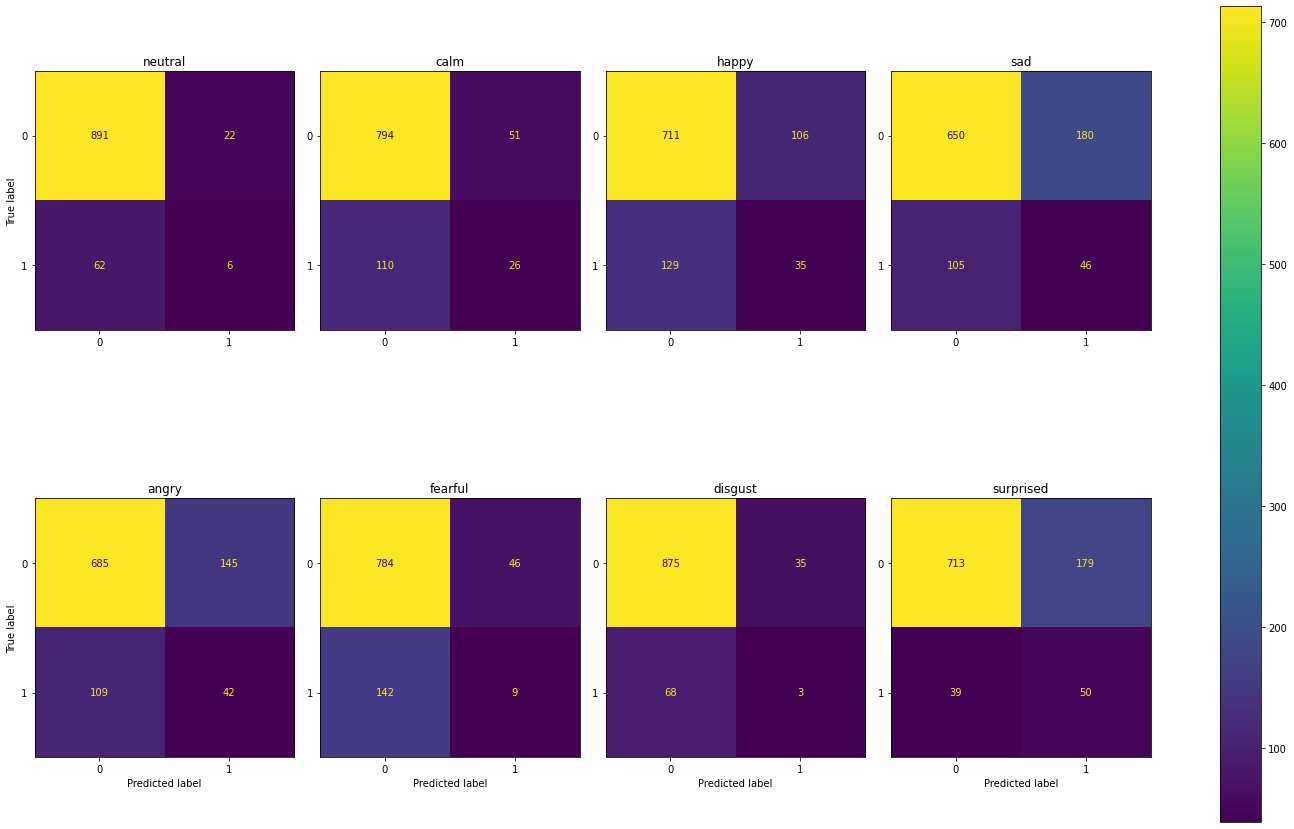

In [ ]:
#dt_mod_full_emo_matrix
displaymat = dt_mod_full_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

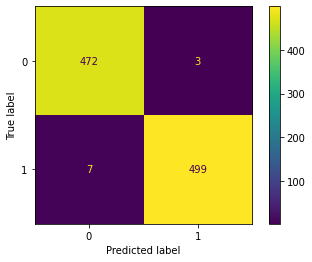

In [ ]:
#dt_full_gender_matrix
displaymat = dt_full_gender_matrix

disp = ConfusionMatrixDisplay(displaymat)
disp.plot()
plt.show()

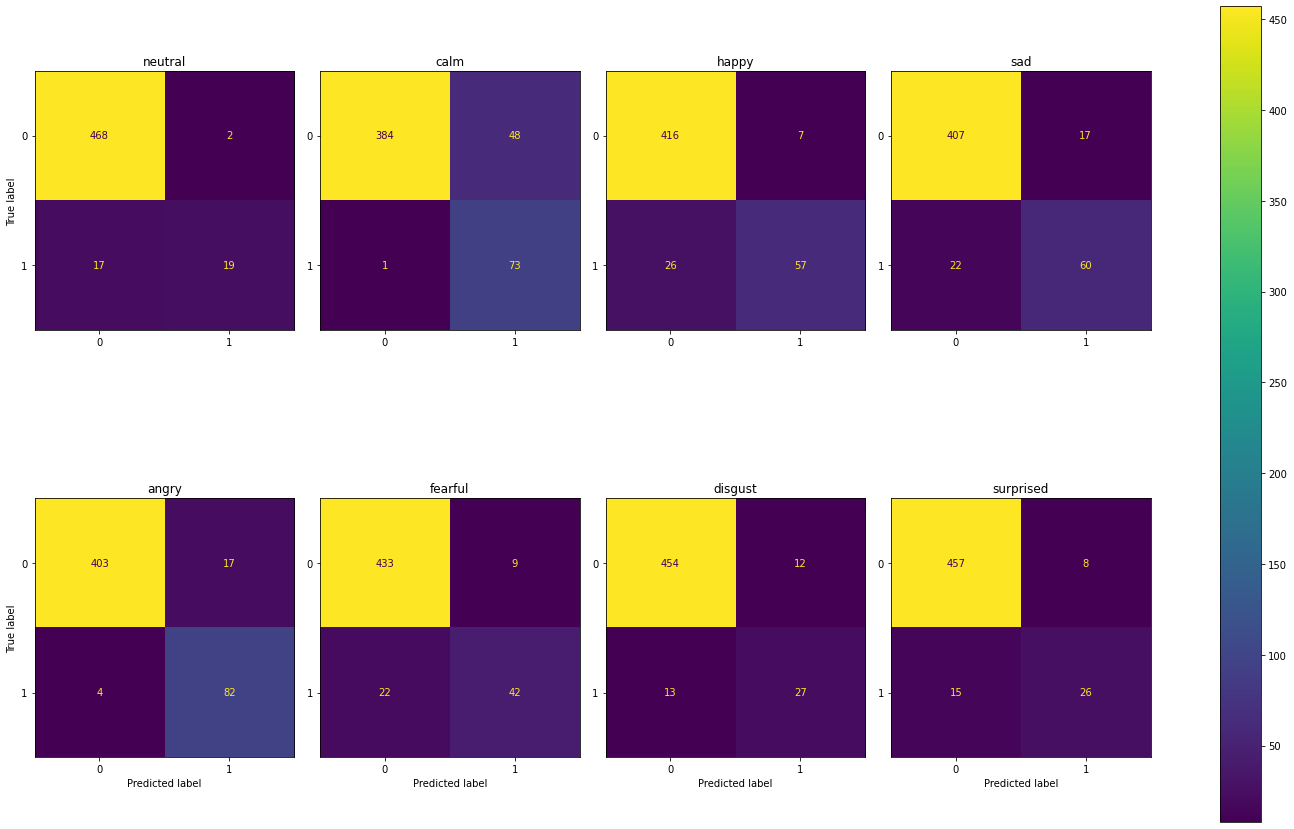

In [ ]:
#dt_male_emo_matrix
displaymat = dt_male_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

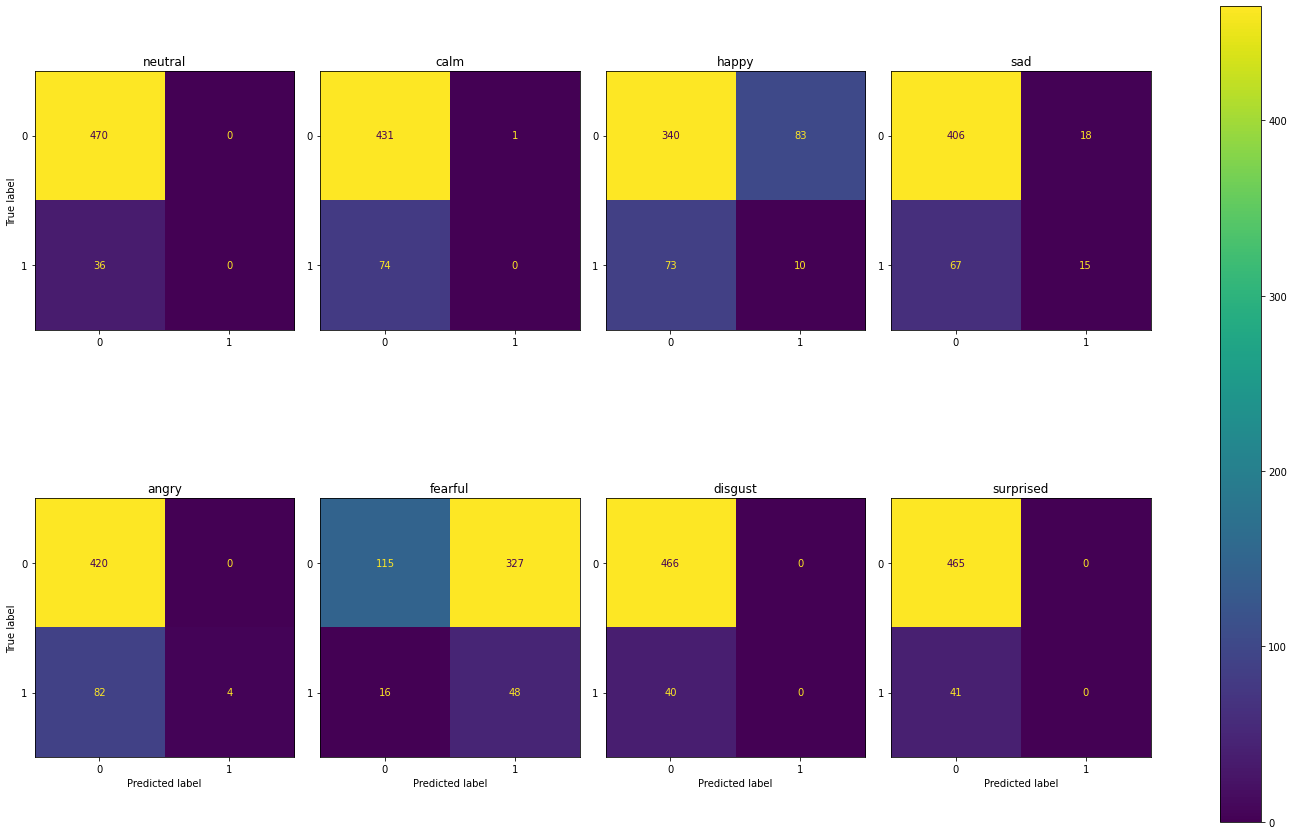

In [ ]:
#dt_mod_male_emo_matrix
displaymat = dt_mod_male_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

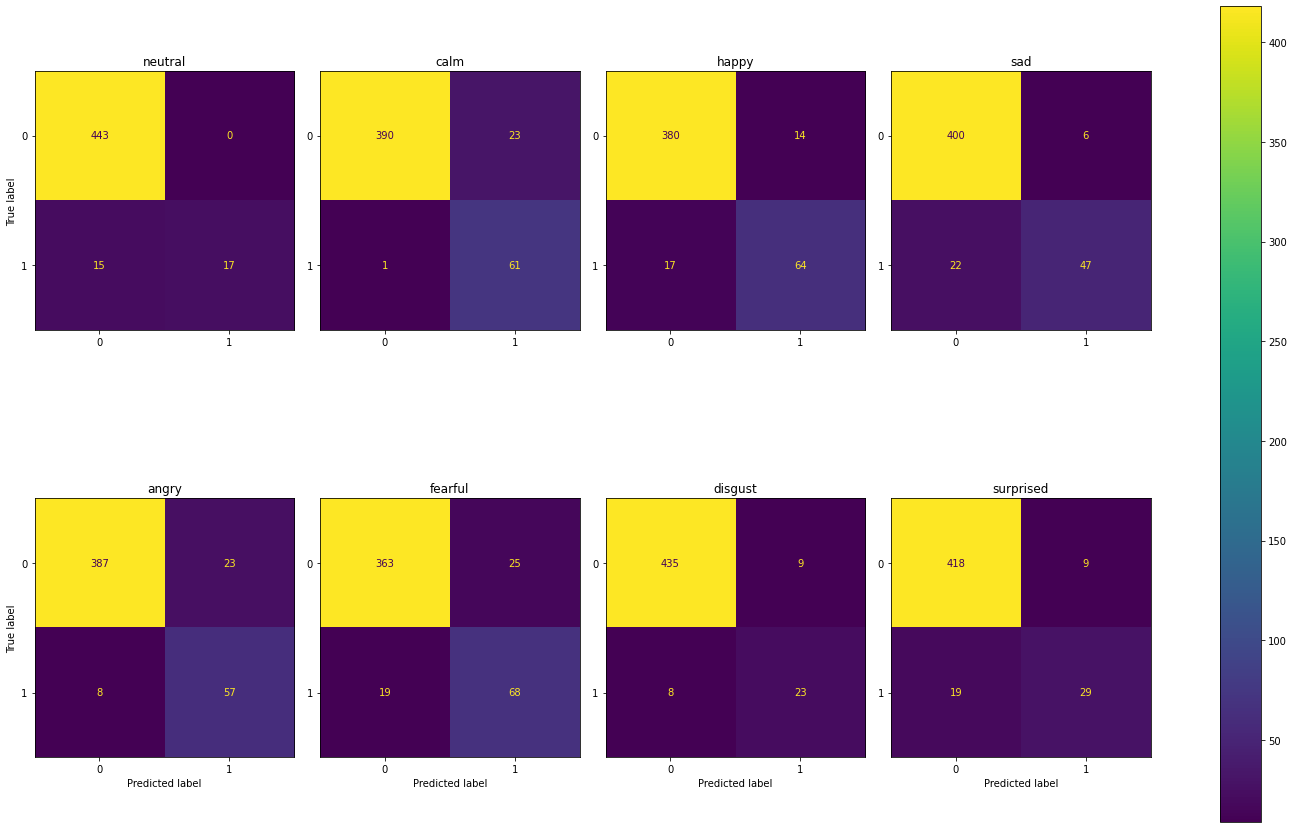

In [ ]:
#dt_female_emo_matrix
displaymat = dt_female_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

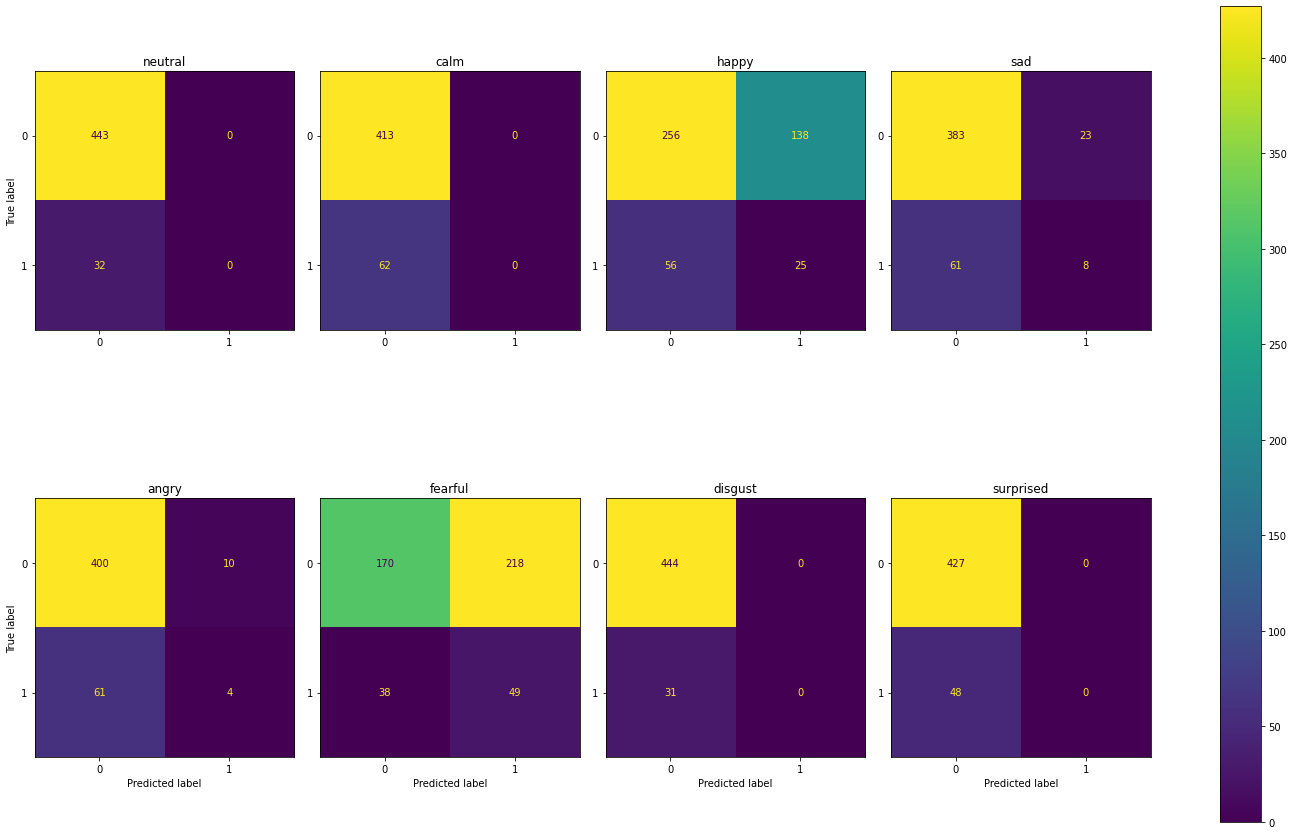

In [ ]:
#dt_mod_female_emo_matrix
displaymat = dt_mod_female_emo_matrix
f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()

labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

for i in range(8):
  label = labels[i]
  disp = ConfusionMatrixDisplay(displaymat[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(label)
  if i<4:
    disp.ax_.set_xlabel('')
  if i%4!=0:
    disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()